# En este ejercicio vamos a entrenar un resolvedor de tickets.#

<div class="alert alert-block alert-info">
El procesamiento del lenguage natural tiene, entre otros usos : 
<br><br>

 - Construcción de **modelos de ML** cuya entrada es texto libre.<br>
 - **Extracción de tópicos** de un texto.<br>
 - **Auto clasificación** de textos.<br>
 - **Analisis sentiente**.<br>
 - **Traducción** entre idiomas.<br>
<br>
</div>

 
Vamos a construir un predictor de tickets, que dado un ticket nuevo con una incidencia, lo categoriza.

## Fases
- ### Carga del dataset y de las stop words
- ### Preprocesado.
- ### Vectorización del dataset con CountVectorizer.
- ### Transformación del dataset.
- ### Comparativa de clasificadores con kfold.


## Carga del dataset 


In [1]:
import sys
import IPython
import numpy as np
import pandas as pd
import sklearn as sk


import warnings
warnings.filterwarnings('ignore')
import pandas as pd

# Load data
df = pd.read_csv("datasets/tickets-jobs.csv")

df.head(4)

,id,subject,content,problem
0,169515,Cuenta de uso general para el proyecto IoT en ...,Buenas tardes Queriamos solicitaros una cuenta...,add-ftp-user
1,169982,Wikis Peticion de creacion de wiki iot-SmartCi...,Hola Necesitamos la creacion de una wiki iot-s...,create-wiki
2,170229,MV para pruebas de cyclops en M M,Hola Jaime Como te he comentado estamos hacien...,crearmaquinavirtual
3,170397,WIKIS Creacion de la wiki network-dev,Creacion de wiki para dev Ruben Montoro Tercia...,create-wiki


### Instalamos las stop words###


Las stop words son palabras que no añaden significado a un texto (pronombres, interjecciones, frases hechas)


In [2]:
!pip install stop-words

You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
from stop_words import get_stop_words
##  Como nos llegan tickets en dos idiomas añadimos las palabras de ambos idiomas
stop  = get_stop_words('spanish') + get_stop_words('english')

print(stop)

['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'estaba', 'estabais', 'estaban', 'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará', 'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas', 'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras', 'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis', 'estuviéramos', 'estuviésemos', 'estuvo', 'está', 'estábamos', 'estáis', 'están', 'estás', 'esté', 'estéis', 'estén', 'estés', 'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fu

## Preprocesado ##

Quitamos : 
 - casos demasiados infrecuentes, 
 - columnas vacias,  
además, concatenamos el campo "Asunto" y "Cuerpo" de los tickets.



In [4]:
import pandas as pd
NUM_TICKETS=1000

# Preprocess
CASES_TO_DELETE=["Problem" ,
                 "artifactory-permisos",
                 "integration-dcip-github",
                 "restart-VM",
                 "artifactory-add-user-grupo",
                 "artifactory-add-repo-local",
                 "crear-maquina-virtual" , "un", "Otros"]
for case in CASES_TO_DELETE : df = df.drop(df[df.problem == case].index)
df["problem"][df.problem == "unsuspend"] = "unsuspend-pdihub-user" 

# Cargamos DF
df.dropna(subset = ['problem'],inplace=True) 

print(df.shape)
print(df.problem.value_counts())



# Quitamos los campos vacios
df['subject'].fillna('', inplace=True)
df['content'].fillna('', inplace=True)
# Un solo campo concatenando Subject + Content
df["ticket"] = df['content'] + df['subject']
# Borrar columnas
del df['content'] 
del df['subject']
print(df.shape)
df.tail(4)


(394, 4)
unsuspend-pdihub-user       102
add-github-user              76
add-pdihub-user              56
add-users-to-tenant-kilo     34
add-jira-user                31
add-users-to-tenant          31
create-wiki                  23
crearmaquinavirtual          21
add-ftp-user                 20
Name: problem, dtype: int64
(394, 3)


,id,problem,ticket
714,226651,unsuspend-pdihub-user,Buenos dias Mi usuario art has sido marcado co...
715,226624,add-github-user,Buenos dias He perdido el acceso al repositori...
717,226615,unsuspend-pdihub-user,Estimados Desde el problema suscitado hace un ...
722,226586,crearmaquinavirtual,Hola de cara a poder instalar una maquina para...


## Vectorización del dataset con CountVectorizer.

Normalmente para generar el dataset el procedimiento es stopword + stemming (quitar plurales) + bag of words.<br> <br> 
En este caso, vamos a usar [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), el cual en un solo paso:<br> 
 - aplica las stop words, 
 - genera los n-grams (agrupa palabras en grupos de n)
 - cuenta las frecuencias, para generar las features.

El resultado es un dataset cuyas columnas son los n-gramas mas frecuentes, la fila es cada uno de los ticket y cada celda es la frecuencia de ese n-grama en ese ticket.

In [5]:
# CountVectorizer implements both tokenization and occurrence counting
#  in a single class:
MAX_FEATURES=100

from sklearn.feature_extraction.text import CountVectorizer
### 
count = CountVectorizer( max_df=.1,
                        max_features=MAX_FEATURES,
                        stop_words=stop,
                        ngram_range=(1, 3))

X = count.fit_transform(df['ticket'].values)
print(count)
print(X.toarray()  , X.shape , X[0].shape  )


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=100, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['a', 'al', 'algo', 'algunas', 'algunos', 'ante', 'antes', 'como', 'con', 'contra', 'cual', 'cuando', 'de', 'del', 'desde', 'donde', 'durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais', 'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta', 'e..."wouldn't", 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself', 'yourselves'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [5 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (394, 100) (1, 100)


Eso son los ngramas mas frecuentes, que han resultado en features.

In [6]:
print(count.get_feature_names())



['activity', 'antonio', 'asunto', 'aura', 'borja', 'buenas tardes', 'cid', 'cid image', 'cid image png', 'cloud', 'cloud eu', 'cloud eu mad', 'com asunto', 'com signature', 'comunicacion', 'comunicacion madrid', 'copia', 'correo', 'cuenta pdihub', 'datos', 'david', 'david peralesferreratelefonica', 'david peralesferreratelefonica com', 'destinatario', 'dev', 'distrito telefonica', 'dormant', 'enviado', 'epgtid', 'error', 'eu', 'eu mad', 'eu mad instantservers', 'francisco', 'ftp', 'garcia', 'gb', 'gif', 'github telefonica', 'gomez', 'gracias saludos', 'hola necesitamos', 'http', 'http www', 'https pdihub', 'https pdihub hi', 'image', 'image png', 'informacion', 'instantservers', 'instantservers telefonica', 'instantservers telefonica com', 'javier', 'jose', 'lourdes', 'luis', 'mad', 'mad instantservers', 'mad instantservers telefonica', 'manager', 'maquina', 'marcos', 'mismo', 'muchas gracias saludo', 'necesitaria', 'nombre', 'nueva', 'oeste', 'openstack', 'organizacion telefonica', 'o

## Transformación del dataset.


- Generamos un dataset a partir del CountVectorizer, por legibilidad.

In [7]:
from pandas import DataFrame

df_vectorizado = DataFrame(X.A, columns=count.get_feature_names() ) 

df_vectorizado = df_vectorizado.astype(bool).astype(int)

# Añadimos el campo problem, que sera el campo a predecir
df_vectorizado["problem"] = df["problem"] 
df_vectorizado["id"] = df["id"] 
df_vectorizado.dropna(subset = ['problem'],inplace=True) 

df_vectorizado.head()


,activity,antonio,asunto,aura,borja,buenas tardes,cid,cid image,cid image png,cloud,...,telefonica com,telefonica com signature,telefonica github,tener,usuario github,video,wiki,www,problem,id
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,add-ftp-user,169515.0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,create-wiki,169982.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,crearmaquinavirtual,170229.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,create-wiki,170397.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,create-wiki,171179.0


In [8]:
## Generamos X e Y, para entrenar los modelos

In [9]:
from sklearn.preprocessing import LabelEncoder
import sys

try             : del df_vectorizado["id"] 
except Exception: pass

y = df_vectorizado.iloc[:,-1]
X = df_vectorizado.drop('problem', axis=1)

y.head()




0           add-ftp-user
1            create-wiki
2    crearmaquinavirtual
3            create-wiki
4            create-wiki
Name: problem, dtype: object

In [10]:
X.head()

,activity,antonio,asunto,aura,borja,buenas tardes,cid,cid image,cid image png,cloud,...,tardes,teams,telefonica com,telefonica com signature,telefonica github,tener,usuario github,video,wiki,www
0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
y.head()

0           add-ftp-user
1            create-wiki
2    crearmaquinavirtual
3            create-wiki
4            create-wiki
Name: problem, dtype: object

## Comparativa de clasificadores con kfold.

Como en el ejercicio anterior, probamos una bateria de modelos y validamos su score con k-fold.


In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from mlxtend.classifier import EnsembleVoteClassifier
from xgboost import XGBClassifier

NUM_SPLITS=8

kfold = KFold(n_splits=NUM_SPLITS)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                     test_size=0.20,
                     random_state=1)
    
    
names = ["Nearest Neighbors", 
         "Linear SVM", 
         "RBF SVM", 
         "Decision Tree", 
         "Random Forest", 
         "MLPClassifier", 
         "AdaBoost",
         "XGBoost" 
        ]


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    XGBClassifier()
]


for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores = model_selection.cross_val_score(clf, X, y,  cv=kfold )
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), name))
    score = clf.score(X_test, y_test)

# Practicamos tambien el voto de algoritmos, por si fuera mas preciso
eclf = EnsembleVoteClassifier(clfs=classifiers, 
                              weights=[1,1,1,1,1,1,1,1])
scores = model_selection.cross_val_score(eclf, X, y,  cv=kfold )
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), "EnsembleVoteClassifier"))
  
print("Fin")




Accuracy: 0.21 (+/- 0.10) [Nearest Neighbors]
Accuracy: 0.22 (+/- 0.18) [Linear SVM]
Accuracy: 0.22 (+/- 0.15) [RBF SVM]
Accuracy: 0.30 (+/- 0.08) [Decision Tree]
Accuracy: 0.15 (+/- 0.10) [Random Forest]
Accuracy: 0.26 (+/- 0.12) [MLPClassifier]
Accuracy: 0.20 (+/- 0.09) [AdaBoost]
Accuracy: 0.26 (+/- 0.16) [XGBoost]
Accuracy: 0.31 (+/- 0.13) [EnsembleVoteClassifier]
Fin


(261, 2)


Text(0.5,1,'Clasificador RandomForestClassifier')

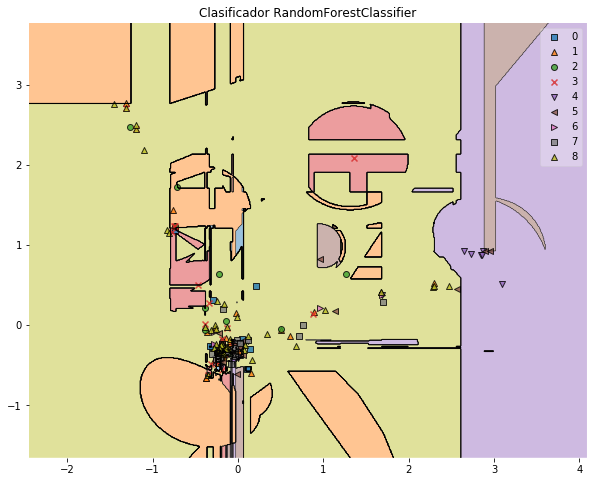

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA



le = LabelEncoder()
y2 = le.fit_transform(y)
y = y2

#print(X,y)

###### Generamos un nuevo dataframe con solo dos componentes.
pca_2c = PCA(n_components=2)
X_pca_2c = pca_2c.fit_transform(X)
print(X_pca_2c.shape)


pca_2c.explained_variance_ratio_.sum()

###### Miramos el gráfico
from sklearn.naive_bayes import GaussianNB 
from mlxtend.plotting import plot_decision_regions



X     = X_pca_2c
model = eclf  
clf   = model
clf.fit(X, y)

# Generamos el gráfico
fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=X, y=y, clf=clf)


plt.title("Clasificador RandomForestClassifier")


